In [44]:
import polars as pl
import json
import numpy as np
import scipy.stats as sp


def sacred_to_df(sacred_logfile: str):
    with open(sacred_logfile, "r") as f:
        data: dict[str, list] = json.load(f)

    res = dict[str, list]()
    length = 0
    for key, values in data.items():
        length = max(length, len(values))
        new_values = list[float]()
        for v in values:
            match v:
                case float() | int():
                    new_values.append(v)
                case dict():
                    if "py/reduce" in v:
                        # Ignore this
                        continue
                    dtype = v.get("dtype", None)
                    if dtype is None:
                        raise NotImplementedError(f"Unknown dtype: {v}")
                    match v["dtype"]:
                        case "float64":
                            new_values.append(float(v["value"]))
                        case _:
                            raise NotImplementedError(f"Unknown dtype: {v['dtype']}")
                case _:
                    raise NotImplementedError(f"Unknown: {v}")
        if len(new_values) > 0:
            if "return" in key or "gems" in key or "episode" in key:
                continue
            key = key.replace("_", "-")
            res[key] = new_values

    df = pl.DataFrame(res)
    df = df.with_columns(pl.col("ep-length-mean-T").alias("time-step"))
    for column in df.columns:
        if column.endswith("-T"):
            df = df.drop(column)
        elif column.endswith("-mean"):
            df = df.rename({column: column.replace("-mean", "")})
    return df


def round_col(df: pl.DataFrame, col_name: str, round_value: int):
    col = df[col_name] / round_value
    col = col.round(0)
    col = col * round_value
    col = col.cast(pl.Int64)
    return df.with_columns(col.alias(col_name))


def stats_by(col_name: str, df: pl.DataFrame, replace_inf: bool):
    if len(df) == 0:
        return df
    grouped = df.group_by(col_name)
    cols = [col for col in df.columns if col != col_name]
    res = grouped.agg(
        [pl.mean(col).alias(f"mean-{col}") for col in cols]
        + [pl.std(col).alias(f"std-{col}") for col in cols]
        + [pl.min(col).alias(f"min-{col}") for col in cols]
        + [pl.max(col).alias(f"max-{col}") for col in cols]
    ).sort(col_name)

    # Compute confidence intervals for 95% confidence
    # https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy
    confidence_intervals = []
    counts = grouped.len().sort(col_name)["len"]
    scale = (counts**0.5).to_numpy().astype(np.float32)
    for col in cols:
        mean = res[f"mean-{col}"].to_numpy().astype(np.float32)
        # Avoid zero std with +1e-8, otherwise a "inf" * 0 will be computed by scipy, leading to NaN
        std = res[f"std-{col}"].to_numpy().astype(np.float32) + 1e-8
        # Use scipy.stats.t if the sample size is small (then degree of freedom, df, is n_samples - 1)
        # Use scipy.stats.norm if the sample size is large
        lower, upper = sp.norm.interval(0.95, loc=mean, scale=std / scale)
        plus95 = pl.Series(name=f"{col}-plus95", values=upper)
        minus95 = pl.Series(name=f"{col}-minus95", values=lower)
        confidence_intervals += [plus95, minus95]

    res = res.with_columns(confidence_intervals)
    if replace_inf:
        for series in res.select(pl.col(pl.FLOAT_DTYPES)):
            mask = series.is_infinite() | series.is_nan()
            if mask.any():
                print(f"Replacing inf/nan with 1e20 in {series.name}")
            series[mask] = 1e20
            res = res.with_columns(series)
    return res


# Transform Sacred to CSV

In [45]:
import os 
dfs = []
FOLDER = "sc2/"
for run_num in range(22, 33):
    file = os.path.join(FOLDER, f"{run_num}/info.json")
    new_df = sacred_to_df(file)
    dfs.append(new_df)
df = pl.concat(dfs)
df.write_csv("train-total.csv")


# Plot the results

shape: (2_051, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ battle-wo ┆ dead-alli ┆ dead-enem ┆ ep-length ┆ … ┆ test-dead ┆ test-ep-l ┆ value-los ┆ time-ste │
│ n         ┆ es        ┆ ies       ┆ ---       ┆   ┆ -enemies  ┆ ength     ┆ s         ┆ p        │
│ ---       ┆ ---       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.0       ┆ 3.0       ┆ 0.0       ┆ 24.0      ┆ … ┆ 0.0       ┆ 60.0      ┆ 0.668284  ┆ 0        │
│ 0.0       ┆ 3.0       ┆ 0.0       ┆ 53.0      ┆ … ┆ 0.0       ┆ 60.0      ┆ 0.660797  ┆ 0        │
│ 0.0       ┆ 2.967655  ┆ 0.002695  ┆ 26.97035  ┆ … ┆ 0.21875   ┆ 42.15625  ┆ 0.077895  ┆ 10000    │
│ 0.0       ┆ 3.0       ┆ 0.076433  ┆ 21.265393 ┆ … ┆ 1.4375    ┆ 20.093

/tmp/ipykernel_197877/2669024996.py:88: DeprecationWarning: `FLOAT_DTYPES` is deprecated. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  for series in res.select(pl.col(pl.FLOAT_DTYPES)):


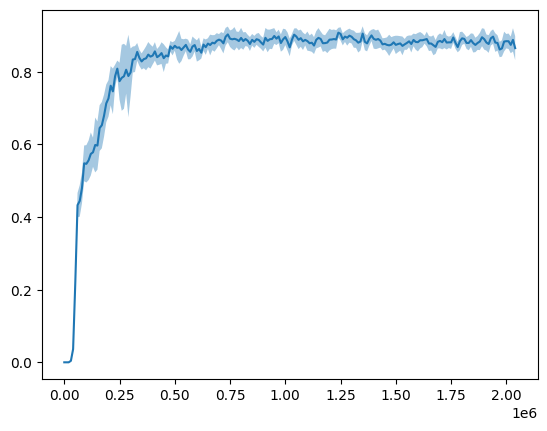

<Figure size 640x480 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
METRICS = [
    "battle-won"
]

df = pl.read_csv("train-total.csv")
df = round_col(df, "time-step", 10_000)
print(df)
df = stats_by("time-step", df, True)
print(df)
print(df.columns)
for metric in METRICS:
    x_ticks = df["time-step"].to_numpy()
    start = df[f"{metric}-minus95"].to_numpy()
    mean = df[f"mean-{metric}"].to_numpy()
    stop = df[f"{metric}-plus95"].to_numpy()
    print(stop.min(), stop.max())
    plt.plot(x_ticks, mean, label="mean")
    plt.fill_between(x_ticks, start, stop, alpha=0.4)
    plt.show()
    plt.clf()